<h1> Imports

In [1]:
'''
Code to run Reptile, following Ocariz's notebooks in the Reptile folder
Note, utils kept here b/c of use of globals (issues when run from files)
'''

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns 
from math import pi as PI
import random
# !pip3 install higher
import torch.nn as nn
import torch
import random
from higher import innerloop_ctx
import warnings

# import backbone model, dataset, and code utils
from models import Neural_Network
from constants import *
import analysis_utils
from data import *

torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

Available device: cpu


<h1> Helper functions

In [2]:
# The Minimum Square Error is used to evaluate the difference between prediction and ground truth
criterion = nn.MSELoss()

def copy_existing_model(model):
    # Function to copy an existing model
    # We initialize a new model
    new_model = Neural_Network()
    # Copy the previous model's parameters into the new model
    new_model.load_state_dict(model.state_dict())
    return new_model

def get_samples_in_good_format(wave, num_samples=10):
    #This function is used to sample data from a wave
    sample_data = wave.get_samples(num_samples=num_samples)
    x = sample_data["input"]
    y_true = sample_data["output"]
    # We add [:,None] to get the right dimensions to pass to the model: we want K x 1 (we have scalars inputs hence the x 1)
    # Note that we convert everything torch tensors
    x = torch.tensor(x[:,None])
    y_true = torch.tensor(y_true[:,None])
    return x,y_true
#     # set to whatever the base device is (GPU or CPU)
#     # help from: https://stackoverflow.com/questions/46704352/porting-pytorch-code-from-cpu-to-gpu
#     return x.to(device),y_true.to(device) 

def initialization_to_store_meta_losses():
  # This function creates lists to store the meta losses
  global store_train_loss_meta; store_train_loss_meta = []
  global store_test_loss_meta; store_test_loss_meta = []

def test_set_validation(model,new_model,wave,lr_inner,k,store_test_loss_meta):
    # This functions does not actually affect the main algorithm, it is just used to evaluate the new model
    new_model,losses = training(model, wave, lr_inner, k)
    # Obtain the loss
    loss = evaluation(new_model, wave)
    # Store loss
    store_test_loss_meta.append(loss)
    return losses

def train_set_evaluation(new_model,wave,store_train_loss_meta):
    loss = evaluation(new_model, wave)
    store_train_loss_meta.append(loss) 

def print_losses(epoch,store_train_loss_meta,store_test_loss_meta,printing_step=1000):
  if epoch % printing_step == 0:
    print(f'Epochh : {epoch}, Average Train Meta Loss : {np.mean(store_train_loss_meta)}, Average Test Meta Loss : {np.mean(store_test_loss_meta)}')

#This is based on the paper update rule, we calculate the difference between parameters and then this is used by the optimizer, rather than doing the update by hand
def reptile_parameter_update(model,new_model):
  # Zip models for the loop
  zip_models = zip(model.parameters(), new_model.parameters())
  for parameter, new_parameter in zip_models:
    if parameter.grad is None:
      parameter.grad = torch.tensor(torch.zeros_like(parameter))
    # Here we are adding the gradient that will later be used by the optimizer
    parameter.grad.data.add_(parameter.data - new_parameter.data)

# Define commands in order needed for the metaupdate
# Note that if we change the order it doesn't behave the same
def metaoptimizer_update(metaoptimizer):
  # Take step
  metaoptimizer.step()
  # Reset gradients
  metaoptimizer.zero_grad()

def metaupdate(model,new_model,metaoptimizer):
  # Combine the two previous functions into a single metaupdate function
  # First we calculate the gradients
  reptile_parameter_update(model,new_model)
  # Use those gradients in the optimizer
  metaoptimizer_update(metaoptimizer)

def evaluation(new_model, wave, item = True):
    # Get data
    x, label = get_samples_in_good_format(wave)
    # Make model prediction
    prediction = new_model(x)
    # Get loss
    if item == True: #Depending on whether we need to return the loss value for storing or for backprop
      loss = criterion(prediction,label).item()
    else:
      loss = criterion(prediction,label)
    return loss

def training(model, wave, lr_k, k):
    # Create new model which we will train on
    new_model = copy_existing_model(model)
    # Define new optimizer
    koptimizer = torch.optim.SGD(new_model.parameters(), lr=lr_k)
    # Update the model multiple times, note that k>1 (do not confuse k with K)
    losses = []
    for i in range(k):
        # Reset optimizer
        koptimizer.zero_grad()
        # Evaluate the model
        loss = evaluation(new_model, wave, item = False)
        # Backpropagate
        loss.backward()
        koptimizer.step()
        losses.append(loss.item())
    return new_model, losses

<h1> Reptile

In [3]:
#Define important variables
epochs = num_epochs * T # number of epochs
lr_meta=0.001 # Learning rate for meta model (outer loop)
printing_step=1000 # how many epochs should we wait to print the loss
lr_k=0.01 # Internal learning rate
k=5 # Number of internal updates for each task

# Initializations
initialization_to_store_meta_losses()
model = Neural_Network()
metaoptimizer = torch.optim.Adam(model.parameters(), lr=lr_meta)

In [4]:
'''
Create dataset
'''
# specify the number of tasks to sample per meta-set
# note: we end up sampling tasks at random, so sizes are not particularly relevant
# artifact of the way we structured the dataset earlier 
meta_train_size=10000
meta_val_size=1000
meta_test_size=1000
meta_train_eval_size = 20

dataset = RegressionDomain(amp_min=amp_min, amp_max=amp_max, 
                           phase_min=phase_min, phase_max=phase_max, 
                           train_size=meta_train_size, val_size=meta_val_size, test_size=meta_test_size)

meta_val_set = dataset.get_meta_val_batch()
meta_test_set = dataset.get_meta_test_batch()

In [5]:
# Training loop
for epoch in range(epochs):
        
    # Sample a sine wave (Task from training data)
    wave = dataset.get_meta_train_batch(task_batch_size=1)

    # Update model predefined number of times based on k
    new_model,_ = training(model, wave[0], lr_k, k)

    # Evalaute the loss for the training data
    train_set_evaluation(new_model,wave[0],store_train_loss_meta)     
    
    #Meta-update --> Get gradient for meta loop and update
    metaupdate(model,new_model,metaoptimizer)
    
    # Evalaute the loss for the test data
    # Note that we need to sample the wave from the test data
    wave = dataset.get_meta_val_batch(task_batch_size=1)
    test_set_validation(model,new_model,wave[0],lr_k,k,store_test_loss_meta)

    # Print losses every 'printing_step' epochs
    print_losses(epoch,store_train_loss_meta,store_test_loss_meta,printing_step)

Epochh : 0, Average Train Meta Loss : 0.31318166851997375, Average Test Meta Loss : 7.635172367095947


<ipython-input-2-94f2234b00e2>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x[:,None])
<ipython-input-2-94f2234b00e2>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_true = torch.tensor(y_true[:,None])
<ipython-input-2-94f2234b00e2>:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  parameter.grad = torch.tensor(torch.zeros_like(parameter))


Epochh : 1000, Average Train Meta Loss : 2.2108276298922767, Average Test Meta Loss : 2.0172824171105668
Epochh : 2000, Average Train Meta Loss : 1.7053038490859829, Average Test Meta Loss : 1.5909115785510857
Epochh : 3000, Average Train Meta Loss : 1.4590862448426862, Average Test Meta Loss : 1.327020225114655
Epochh : 4000, Average Train Meta Loss : 1.275214175650337, Average Test Meta Loss : 1.134882091877957
Epochh : 5000, Average Train Meta Loss : 1.1239877696370266, Average Test Meta Loss : 1.0000415980665323
Epochh : 6000, Average Train Meta Loss : 1.0036163470235209, Average Test Meta Loss : 0.8940683421557013
Epochh : 7000, Average Train Meta Loss : 0.9025949065264243, Average Test Meta Loss : 0.804106604433534
Epochh : 8000, Average Train Meta Loss : 0.8202770355784678, Average Test Meta Loss : 0.7320274474338948
Epochh : 9000, Average Train Meta Loss : 0.7512476268261629, Average Test Meta Loss : 0.670789918907111
Epochh : 10000, Average Train Meta Loss : 0.6934954195888292

Epochh : 78000, Average Train Meta Loss : 0.13647021599380407, Average Test Meta Loss : 0.12151050236459272
Epochh : 79000, Average Train Meta Loss : 0.13513841312081923, Average Test Meta Loss : 0.12033158335328908
Epochh : 80000, Average Train Meta Loss : 0.13385006273114122, Average Test Meta Loss : 0.1191705951057149
Epochh : 81000, Average Train Meta Loss : 0.13258177667491056, Average Test Meta Loss : 0.11803374010155981
Epochh : 82000, Average Train Meta Loss : 0.13132654719934397, Average Test Meta Loss : 0.11693738447811426
Epochh : 83000, Average Train Meta Loss : 0.1301244331973532, Average Test Meta Loss : 0.11587891387978996
Epochh : 84000, Average Train Meta Loss : 0.1289391383994853, Average Test Meta Loss : 0.11483675143773232
Epochh : 85000, Average Train Meta Loss : 0.12780384313212145, Average Test Meta Loss : 0.11383102629810532
Epochh : 86000, Average Train Meta Loss : 0.12665083098377017, Average Test Meta Loss : 0.11281114057494528
Epochh : 87000, Average Train M

Epochh : 154000, Average Train Meta Loss : 0.08300565915494151, Average Test Meta Loss : 0.07403369712905802
Epochh : 155000, Average Train Meta Loss : 0.08264646797817075, Average Test Meta Loss : 0.0737025670536819
Epochh : 156000, Average Train Meta Loss : 0.08228143914156272, Average Test Meta Loss : 0.07337777876443358
Epochh : 157000, Average Train Meta Loss : 0.08192518433976925, Average Test Meta Loss : 0.07306877589000133
Epochh : 158000, Average Train Meta Loss : 0.08158457466346382, Average Test Meta Loss : 0.07276989737223707
Epochh : 159000, Average Train Meta Loss : 0.08122746619147996, Average Test Meta Loss : 0.07245455230700187
Epochh : 160000, Average Train Meta Loss : 0.08088773003709379, Average Test Meta Loss : 0.07214362643746211
Epochh : 161000, Average Train Meta Loss : 0.08053997045704725, Average Test Meta Loss : 0.07184217545394704
Epochh : 162000, Average Train Meta Loss : 0.08022693925124824, Average Test Meta Loss : 0.07154445573849288
Epochh : 163000, Ave

Epochh : 230000, Average Train Meta Loss : 0.06397732837902667, Average Test Meta Loss : 0.05722362447704256
Epochh : 231000, Average Train Meta Loss : 0.06380023064384613, Average Test Meta Loss : 0.057067350858525275
Epochh : 232000, Average Train Meta Loss : 0.06362787818830914, Average Test Meta Loss : 0.056907956656445435
Epochh : 233000, Average Train Meta Loss : 0.06346021702933063, Average Test Meta Loss : 0.05676694525215705
Epochh : 234000, Average Train Meta Loss : 0.06329714882415431, Average Test Meta Loss : 0.05661837549018454
Epochh : 235000, Average Train Meta Loss : 0.06313286343332761, Average Test Meta Loss : 0.05646856590930669
Epochh : 236000, Average Train Meta Loss : 0.06296872126462298, Average Test Meta Loss : 0.05632540441861287
Epochh : 237000, Average Train Meta Loss : 0.06280583598960952, Average Test Meta Loss : 0.05617951262211654
Epochh : 238000, Average Train Meta Loss : 0.06265223542435959, Average Test Meta Loss : 0.056038279222131324
Epochh : 239000,

Epochh : 305000, Average Train Meta Loss : 0.05412264438155721, Average Test Meta Loss : 0.048496374390706566
Epochh : 306000, Average Train Meta Loss : 0.054029701975482694, Average Test Meta Loss : 0.04840668264465334
Epochh : 307000, Average Train Meta Loss : 0.05393092346770655, Average Test Meta Loss : 0.04831980752239132
Epochh : 308000, Average Train Meta Loss : 0.05383240950653249, Average Test Meta Loss : 0.04822814473761157
Epochh : 309000, Average Train Meta Loss : 0.05373914209353107, Average Test Meta Loss : 0.04814472296162063
Epochh : 310000, Average Train Meta Loss : 0.053640063541738246, Average Test Meta Loss : 0.04805937542121311
Epochh : 311000, Average Train Meta Loss : 0.053541716075332195, Average Test Meta Loss : 0.047972629943937355
Epochh : 312000, Average Train Meta Loss : 0.05344799638577648, Average Test Meta Loss : 0.0478940322709344
Epochh : 313000, Average Train Meta Loss : 0.053351886940385396, Average Test Meta Loss : 0.04780645995634705
Epochh : 31400

Epochh : 380000, Average Train Meta Loss : 0.04810591933844561, Average Test Meta Loss : 0.043192564756018965
Epochh : 381000, Average Train Meta Loss : 0.048039442971445294, Average Test Meta Loss : 0.04313005742471731
Epochh : 382000, Average Train Meta Loss : 0.047972797699498894, Average Test Meta Loss : 0.043074854153662134
Epochh : 383000, Average Train Meta Loss : 0.047915268243983414, Average Test Meta Loss : 0.043017305554388936
Epochh : 384000, Average Train Meta Loss : 0.04785134965182722, Average Test Meta Loss : 0.042965032153448664
Epochh : 385000, Average Train Meta Loss : 0.0477906035753327, Average Test Meta Loss : 0.04291652419682223
Epochh : 386000, Average Train Meta Loss : 0.04772430830495238, Average Test Meta Loss : 0.04285980231800682
Epochh : 387000, Average Train Meta Loss : 0.04765947992631881, Average Test Meta Loss : 0.04280692676834974
Epochh : 388000, Average Train Meta Loss : 0.04759816676371115, Average Test Meta Loss : 0.04275042858197876
Epochh : 3890

Epochh : 455000, Average Train Meta Loss : 0.044054230433908353, Average Test Meta Loss : 0.03962195810771266
Epochh : 456000, Average Train Meta Loss : 0.04400971737666909, Average Test Meta Loss : 0.0395841423166413
Epochh : 457000, Average Train Meta Loss : 0.04396217453796567, Average Test Meta Loss : 0.03954484024551099
Epochh : 458000, Average Train Meta Loss : 0.043917464117967785, Average Test Meta Loss : 0.03950219153518061
Epochh : 459000, Average Train Meta Loss : 0.04387303270465637, Average Test Meta Loss : 0.039462588906613735
Epochh : 460000, Average Train Meta Loss : 0.043826661549356986, Average Test Meta Loss : 0.0394216816627921
Epochh : 461000, Average Train Meta Loss : 0.04378272174833429, Average Test Meta Loss : 0.03938564106685614
Epochh : 462000, Average Train Meta Loss : 0.043738017332014816, Average Test Meta Loss : 0.03935040193719919
Epochh : 463000, Average Train Meta Loss : 0.043694958918543886, Average Test Meta Loss : 0.03931190575116163
Epochh : 464000

Epochh : 530000, Average Train Meta Loss : 0.04121592218136808, Average Test Meta Loss : 0.03713589890454504
Epochh : 531000, Average Train Meta Loss : 0.04118095241503536, Average Test Meta Loss : 0.03710380301637553
Epochh : 532000, Average Train Meta Loss : 0.04115031442487513, Average Test Meta Loss : 0.03707540659317501
Epochh : 533000, Average Train Meta Loss : 0.04111679072207422, Average Test Meta Loss : 0.03704682479958092
Epochh : 534000, Average Train Meta Loss : 0.04108440609909071, Average Test Meta Loss : 0.037018115616744895
Epochh : 535000, Average Train Meta Loss : 0.0410512400528446, Average Test Meta Loss : 0.036990524151406926
Epochh : 536000, Average Train Meta Loss : 0.04101648271258239, Average Test Meta Loss : 0.03696173909299034
Epochh : 537000, Average Train Meta Loss : 0.040983239393110486, Average Test Meta Loss : 0.036931225569089475
Epochh : 538000, Average Train Meta Loss : 0.04094972995203495, Average Test Meta Loss : 0.036903803354506624
Epochh : 539000

Epochh : 605000, Average Train Meta Loss : 0.03905486502751441, Average Test Meta Loss : 0.035246175477932976
Epochh : 606000, Average Train Meta Loss : 0.039027789293695915, Average Test Meta Loss : 0.03522174581492361
Epochh : 607000, Average Train Meta Loss : 0.039003789144819466, Average Test Meta Loss : 0.03520085972842414
Epochh : 608000, Average Train Meta Loss : 0.03897953033306045, Average Test Meta Loss : 0.03518182346100036
Epochh : 609000, Average Train Meta Loss : 0.03895381960552826, Average Test Meta Loss : 0.035159063632105046
Epochh : 610000, Average Train Meta Loss : 0.03892625897501673, Average Test Meta Loss : 0.035138342921723006
Epochh : 611000, Average Train Meta Loss : 0.03889953290562624, Average Test Meta Loss : 0.03511665578311813
Epochh : 612000, Average Train Meta Loss : 0.03887224218673327, Average Test Meta Loss : 0.03509571238976991
Epochh : 613000, Average Train Meta Loss : 0.03884710749113276, Average Test Meta Loss : 0.03507096488846951
Epochh : 61400

Epochh : 680000, Average Train Meta Loss : 0.03731304446270171, Average Test Meta Loss : 0.03371514630936809
Epochh : 681000, Average Train Meta Loss : 0.03729099003013676, Average Test Meta Loss : 0.03369622534459346
Epochh : 682000, Average Train Meta Loss : 0.03726983370131356, Average Test Meta Loss : 0.03367699711311206
Epochh : 683000, Average Train Meta Loss : 0.037248631599108774, Average Test Meta Loss : 0.03365757678273598
Epochh : 684000, Average Train Meta Loss : 0.03722954373204831, Average Test Meta Loss : 0.033639996077327775
Epochh : 685000, Average Train Meta Loss : 0.0372114253802866, Average Test Meta Loss : 0.03362107263441295
Epochh : 686000, Average Train Meta Loss : 0.03719181144370583, Average Test Meta Loss : 0.03360478921048319
Epochh : 687000, Average Train Meta Loss : 0.03716769545077383, Average Test Meta Loss : 0.03358719888072263
Epochh : 688000, Average Train Meta Loss : 0.037146642486697384, Average Test Meta Loss : 0.03356688464412216
Epochh : 689000, 

In [6]:
torch.save(model.state_dict(), "baseline_reptile.pt")

<h1> Few Shot learning with new meta-model

<ipython-input-2-94f2234b00e2>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x[:,None])
<ipython-input-2-94f2234b00e2>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_true = torch.tensor(y_true[:,None])


Step: 0, Error: 2.995114146474749, Var: 4.887627204671044
Step: 1, Error: 0.3946176098957658, Var: 0.1404156915653422
Step: 5, Error: 0.021816651885485042, Var: 0.0004434216557384568


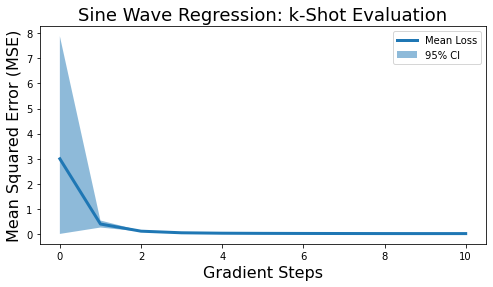

In [17]:
# wave = dataset.get_meta_val_batch(task_batch_size=1)#wave = random.sample(SINE_TEST, 1)
#     test_set_validation(model,new_model,wave[0],lr_k,k,store_test_loss_meta)

all_losses = []
num_eval = 1000
num_k_shots = 11

test_waves = dataset.get_meta_test_batch(task_batch_size=num_eval)
for test_eval in range(num_eval): 
    test_wave = test_waves[test_eval]
    metaTrainLosses = test_set_validation(model,new_model,test_wave,lr_k,num_k_shots,store_test_loss_meta)
    all_losses.append(np.array(metaTrainLosses))
    

all_losses = np.array(all_losses)
np.save(f"reptile_sine_{num_k_shots}.npy", all_losses)
fig, ax = plt.subplots(figsize=(8,4))

mean_loss = np.mean(all_losses, axis=0)

# confidence interval plotting help from: https://stackoverflow.com/questions/59747313/how-to-plot-confidence-interval-in-python
y = mean_loss
x = list(range(num_k_shots))
ci = 1.96 * np.std(all_losses, axis=0)**2/np.sqrt(len(y))

ax_size=16
title_size=18
                                                  
ax.plot(x, y, linewidth=3, label=f"Mean Loss")
# to avoid having MSE < 0
truncated_error = np.clip(y-ci, a_min=0, a_max=None)
ax.fill_between(x, truncated_error, (y+ci), alpha=.5,label=f"95% CI")

ax.set_xlabel("Gradient Steps",fontsize=ax_size)
ax.set_ylabel("Mean Squared Error (MSE)",fontsize=ax_size)
ax.set_title("Sine Wave Regression: k-Shot Evaluation",fontsize=title_size)
ax.legend()#loc="upper right")
plt.savefig("reptile_sine_wave_reg_kshot.png")

analysis_steps=[0,1,5]
for analysis_step in analysis_steps: 
    print(f"Step: {analysis_step}, Error: {mean_loss[analysis_step]}, Var: {ci[analysis_step]}")

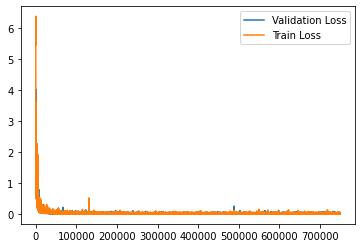

In [16]:
num = 20
avgTrain = []
avgVal = []
metaLosses = store_train_loss_meta
metaValLosses = store_test_loss_meta
for r in range(int(num/2),int(len(metaLosses)-num/2)):
    currSum1 = 0
    for t in range(int(-num/2),int(num/2)):
        currSum1 += metaLosses[r+t]
    currSum1 /= num
    avgTrain.append(currSum1)
    
    currSum2 = 0
    for s in range(int(-num/2),int(num/2)):
        currSum2 += metaValLosses[r+s]
    currSum2 /= num
    avgVal.append(currSum2)
    
    
plt.plot(avgVal) 
plt.plot(avgTrain) 
plt.legend(['Validation Loss','Train Loss'])

In [ ]:
plt.plot(store_train_loss_meta,label = 'Loss')
plt.legend()
plt.xlabel('k shots')

In [13]:
def eval_adjust(model,wave,lr_inner,k, num_samples=10, with_noise=False, noise_dev=1, input_range=[-5.0, 5.0], extract_task_info=False):
    
    # get samples 
    x, label = get_samples_in_good_format(wave, num_samples=num_samples)
    
    # Create new model which we will train on
    new_model = copy_existing_model(model)
    
    # Define new optimizer
    koptimizer = torch.optim.SGD(new_model.parameters(), lr=lr_k)
    
    losses = []
    
    for grad_step in range(k):
        # Reset optimizer
        koptimizer.zero_grad()
        # Evaluate the model
        loss = evaluation(new_model, wave, item = False)
        # Backpropagate
        loss.backward()
        koptimizer.step()
        losses.append(loss.item())
    return losses

all_losses = []
num_eval = 1000
num_k_shots = 11

test_waves = dataset.get_meta_test_batch(task_batch_size=num_eval)
for test_eval in range(num_eval): 
    test_wave = test_waves[test_eval]
    metaTrainLosses = eval_adjust(model,test_wave,lr_k,num_k_shots)
    all_losses.append(np.array(metaTrainLosses))
analysis_steps=[0,1,5]
for analysis_step in analysis_steps: 
    print(f"Step: {analysis_step}, Error: {mean_loss[analysis_step]}, Var: {ci[analysis_step]}")

<ipython-input-2-94f2234b00e2>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x[:,None])
<ipython-input-2-94f2234b00e2>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_true = torch.tensor(y_true[:,None])


Step: 0, Error: 3.0472987083988263, Var: 5.246738964570363
Step: 1, Error: 0.39712528279959225, Var: 0.15220474552885474
Step: 5, Error: 0.022106033206742724, Var: 0.00046797550965395053
